# Imports 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
from slowgrad.engine import SlowgradVar
from slowgrad.models import (
    SlowgradSequential, 
    SlowgradCrossEntropyLoss, 
    SlowgradLinear, 
    SlowgradSigmoid,
)
from slowgrad.optim import SlowgradAdam

## Moon dataset

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 

### Model

In [4]:
model = SlowgradSequential([
    SlowgradLinear(2, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 2, bias = True)
])
ce_loss = SlowgradCrossEntropyLoss()
optim = SlowgradAdam(model.parameters())
print(f'num params : {sum([p.data.numel() for p in model.parameters()])}')

num params : 626


In [5]:
x_data = torch.tensor(X, dtype=torch.float)
y_data = (torch.tensor(y) + 1) // 2
y_data = F.one_hot(y_data, num_classes=2).type(torch.float)

def get_batch(x_data, y_data, batch_size):
    idx = np.random.choice(np.arange(x_data.shape[0]), size=batch_size, replace=False)
    x_batch, y_batch = x_data[idx], y_data[idx]
    return SlowgradVar(x_batch), SlowgradVar(y_batch)

def get_acc_and_ce(x_data, y_data):
    x, y = get_batch(x_data, y_data, x_data.shape[0])

    out = model(x)
    loss = ce_loss(out, y)

    pred, true = out.data, y.data
    pred = F.softmax(pred, dim=-1)
    pred = torch.argmax(pred, dim=-1)
    true = torch.argmax(true, dim=-1)
    acc = torch.sum(pred == true).item() / pred.shape[0]
    return f'loss:{loss.data.item():.2f}, acc:{acc:.2f}'

In [6]:
def train(model, data, epochs, batch_size, optim, metrics):
    x_data, y_data = data
    for epoch in range(epochs):

        optim.zero_grad()

        x_batch, y_batch = get_batch(x_data, y_data, batch_size = batch_size)

        out = model(x_batch)
        loss = ce_loss(out, y_batch)

        loss.backward()
        optim.step()

        if epoch % 100 == 0:
            print(f'[{epoch}/{epochs}] {metrics(x_data, y_data)}')

In [7]:
epochs = 5000
batch_size = 16

train(model, (x_data, y_data), epochs, batch_size, optim, get_acc_and_ce)

[0/5000] loss:1.14, acc:0.50
[100/5000] loss:0.56, acc:0.70
[200/5000] loss:0.45, acc:0.75
[300/5000] loss:0.38, acc:0.82
[400/5000] loss:0.33, acc:0.86
[500/5000] loss:0.30, acc:0.87
[600/5000] loss:0.28, acc:0.90
[700/5000] loss:0.26, acc:0.89
[800/5000] loss:0.25, acc:0.90
[900/5000] loss:0.25, acc:0.90
[1000/5000] loss:0.23, acc:0.91
[1100/5000] loss:0.22, acc:0.91
[1200/5000] loss:0.20, acc:0.91
[1300/5000] loss:0.19, acc:0.91
[1400/5000] loss:0.18, acc:0.91
[1500/5000] loss:0.17, acc:0.92
[1600/5000] loss:0.16, acc:0.93
[1700/5000] loss:0.14, acc:0.93
[1800/5000] loss:0.13, acc:0.94
[1900/5000] loss:0.12, acc:0.96
[2000/5000] loss:0.11, acc:0.94
[2100/5000] loss:0.11, acc:0.96
[2200/5000] loss:0.09, acc:0.97
[2300/5000] loss:0.09, acc:0.97
[2400/5000] loss:0.08, acc:0.98
[2500/5000] loss:0.07, acc:0.98
[2600/5000] loss:0.06, acc:0.98
[2700/5000] loss:0.06, acc:0.99
[2800/5000] loss:0.05, acc:0.98
[2900/5000] loss:0.05, acc:0.99
[3000/5000] loss:0.05, acc:0.99
[3100/5000] loss:0.0

(-1.5978882018302847, 2.1521117981697153)

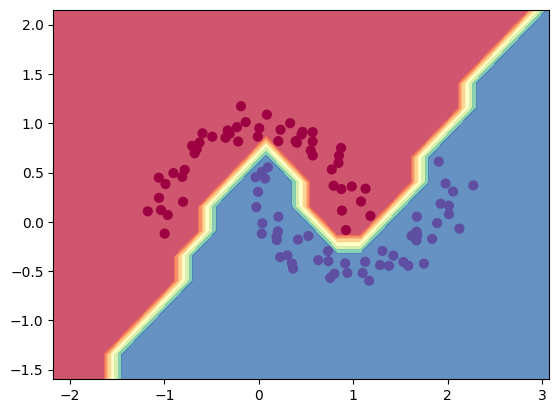

In [8]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

Xmesh = torch.tensor(Xmesh, dtype=torch.float)
inputs = SlowgradVar(Xmesh)
scores = torch.argmax(F.softmax(model(inputs).data, dim=-1), dim=-1)

Z = np.array(scores).reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

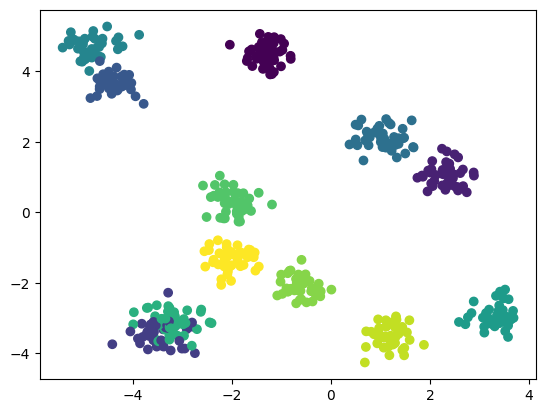

In [10]:
n_class = 12
X, y = make_blobs(n_samples=500, centers=n_class, n_features=2, random_state=42, center_box=(-5, 5), cluster_std=.3)


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

x_data = torch.tensor(X, dtype=torch.float)
y_data = torch.tensor(y, dtype=torch.long)
y_data = F.one_hot(y_data, num_classes=n_class).type(torch.float)

### Model

In [11]:
model = SlowgradSequential([
    SlowgradLinear(2, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, n_class, bias = True),
])
ce_loss = SlowgradCrossEntropyLoss()
optim = SlowgradAdam(model.parameters())
print(f'num params : {sum([p.data.numel() for p in model.parameters()])}')

num params : 796


In [11]:
def get_total_loss(x_data, y_data):
    x, y = get_batch(x_data, y_data, batch_size=x_data.shape[0])
    out = model(x)
    loss = ce_loss(out, y).data.item()
    return f'loss:{loss:.2f}'

In [12]:
epochs = 5000
batch_size = 16

train(model, (x_data, y_data), epochs, batch_size, optim, get_total_loss)

[0/5000] loss:6.19
[100/5000] loss:3.14
[200/5000] loss:2.28
[300/5000] loss:1.88
[400/5000] loss:1.66
[500/5000] loss:1.51
[600/5000] loss:1.39
[700/5000] loss:1.29
[800/5000] loss:1.21
[900/5000] loss:1.13
[1000/5000] loss:1.06
[1100/5000] loss:1.00
[1200/5000] loss:0.94
[1300/5000] loss:0.88
[1400/5000] loss:0.84
[1500/5000] loss:0.80
[1600/5000] loss:0.76
[1700/5000] loss:0.72
[1800/5000] loss:0.69
[1900/5000] loss:0.66
[2000/5000] loss:0.64
[2100/5000] loss:0.62
[2200/5000] loss:0.60
[2300/5000] loss:0.58
[2400/5000] loss:0.57
[2500/5000] loss:0.55
[2600/5000] loss:0.54
[2700/5000] loss:0.52
[2800/5000] loss:0.51
[2900/5000] loss:0.50
[3000/5000] loss:0.50
[3100/5000] loss:0.49
[3200/5000] loss:0.48
[3300/5000] loss:0.47
[3400/5000] loss:0.47
[3500/5000] loss:0.46
[3600/5000] loss:0.46
[3700/5000] loss:0.45
[3800/5000] loss:0.45
[3900/5000] loss:0.44
[4000/5000] loss:0.44
[4100/5000] loss:0.44
[4200/5000] loss:0.43
[4300/5000] loss:0.43
[4400/5000] loss:0.43
[4500/5000] loss:0.43


(-6.001725036255975, 7.498274963744025)

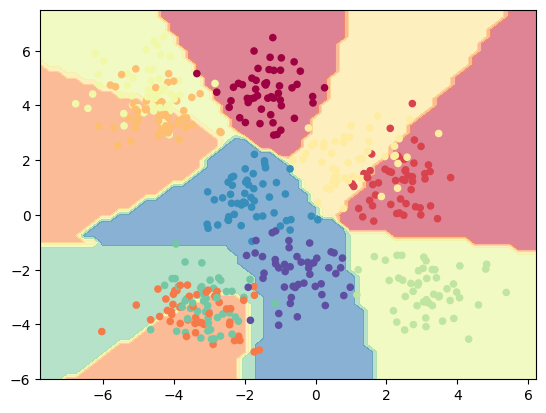

In [13]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

Xmesh = torch.tensor(Xmesh, dtype=torch.float)
inputs = SlowgradVar(Xmesh)
scores = torch.argmax(F.softmax(model(inputs).data, dim=-1), dim=-1)

Z = np.array(scores).reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## MNIST ? 
